<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=170 style="padding: 10px"> 
<b>Little Demo: Transients and Difference Imaging</b> <br>
Contact author(s): Ryan Lau <br>
Last verified to run: 2023-04-27 <br>
LSST Science Pipelines version: Weekly 2023_07 <br>
Container Size: medium

Let's check out a transient lightcurve and see what the (simulated) image products look like. We will utilize the difference-imaging analysis products as well as the Butler throughout this demo. For more information on difference-imaging analysis for transient identification, please refer to the DP0.2 tutorial notebook 07a, "DiaObject Sample Identification." For more information on the Butler, please refer to the tutorial notebooks 04a and 04b.

## 1. Setup and Package Imports

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.visualization import LinearStretch, ImageNormalize
import glob
from PIL import Image

from astropy.stats import sigma_clipped_stats

from lsst.daf.butler import Butler
import lsst.geom as geom
from lsst.afw.image.exposure import Exposure, ExposureF
from lsst.pipe.tasks.registerImage import RegisterConfig, RegisterTask

from lsst.rsp import get_tap_service

Set up some plotting defaults so plots will look nice:

In [18]:
plt.style.use('tableau-colorblind10')

%matplotlib inline

plt.style.use('tableau-colorblind10')

plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

Start the TAP service, which we will use for all data retrieval in this notebook, and create an instance of the Butler pointing to the DP0.2 repository.

In [19]:
service = get_tap_service()

butler = Butler('dp02', collections='2.2i/runs/DP0.2')

Defining the image cutout function

In [20]:
def cutout_im(butler, ra, dec, datasetType, visit, detector, cutoutSideLength=51, **kwargs):
    
    """
    Produce a cutout from a calexp at the given ra, dec position.

    Adapted from cutout_coadd which was adapted from a DC2 tutorial
    notebook by Michael Wood-Vasey.

    """
    
    dataId = {'visit': visit, 'detector': detector}    
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)
    wcs = butler.get('%s.wcs' % datasetType,**dataId)
    xy = geom.PointI(wcs.skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    parameters = {'bbox': bbox}
    cutout_image = butler.get(datasetType, parameters=parameters, **dataId)

    return cutout_image

Defining the three different reference catalogs that will be used in this demo

In [21]:
diff = 'goodSeeingDiff_differenceExp'
difftemp = 'goodSeeingDiff_templateExp'
calexp = 'calexp'

Defining image registration function

In [22]:
def warp_img(ref_img, img_to_warp, ref_wcs, wcs_to_warp):

    config = RegisterConfig()
    task = RegisterTask(name="register", config=config)
    warpedExp = task.warpExposure(img_to_warp, wcs_to_warp, ref_wcs,
                                  ref_img.getBBox())

    return warpedExp

Defining a gif-making function for making an animation of image cutouts

In [23]:
def make_gif(frame_folder):
    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*.png"))]
    frame_one = frames[0]
    frame_one.save("animation.gif", format="GIF", append_images=frames,
               save_all=True, duration=500, loop = 0)

## 2. Lightcurve of a Type Ia Supernova

Set the object ID of a known Type Ia supernova variable in the `ForcedSourceOnDiatObject` and `DiaSource` tables to obtain forced-source and DIA-source photometry

In [33]:
DiaObjID = 1252220598734556212

# Define the query
results = service.search("SELECT fsodo.coord_ra, fsodo.coord_dec, "\
                         "fsodo.diaObjectId, fsodo.ccdVisitId, fsodo.band, "\
                         "fsodo.psfDiffFlux, fsodo.psfDiffFluxErr, "\
                         "fsodo.psfFlux, fsodo.psfFluxErr, "\
                         "cv.expMidptMJD "\
                         "FROM dp02_dc2_catalogs.ForcedSourceOnDiaObject as fsodo "\
                         "JOIN dp02_dc2_catalogs.CcdVisit as cv ON cv.ccdVisitId = fsodo.ccdVisitId "\
                         "WHERE fsodo.diaObjectId = "+str(DiaObjID))

forcedSrc = results.to_table()
# Sort the source catalog by observation time:
forcedSrc.sort('expMidptMJD')
del results

results = service.search("SELECT ra, decl, diaObjectId, diaSourceId, psFlux, psFluxErr, "
                         "filterName, midPointTai, SNR, ccdVisitId, "
                         "scisql_nanojanskyToAbMag(psFlux) AS psAbMag "
                         "FROM dp02_dc2_catalogs.DiaSource "
                         "WHERE diaObjectId = "+str(DiaObjID))
diaSrc = results.to_table()

# Sort the source catalog by observation time:
diaSrc.sort('midPointTai')
del results

Defining start and end dates from each catalog for plotting

In [34]:
mjd_full_start = np.min(forcedSrc['expMidptMJD'])
mjd_full_end = np.max(forcedSrc['expMidptMJD'])

mjd_det_start = np.min(diaSrc['midPointTai'])
mjd_det_end = np.max(diaSrc['midPointTai'])

Plotting light curves from forced photometry and DiaSource photometry

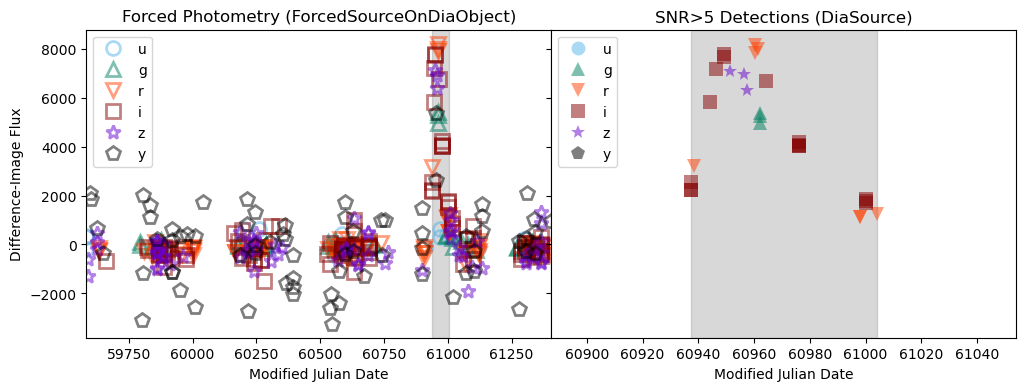

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, sharex=False)

for f, filt in enumerate(plot_filter_labels):
    fx = np.where(forcedSrc['band'] == filt)[0]
    ax[0].plot(forcedSrc['expMidptMJD'][fx], forcedSrc['psfDiffFlux'][fx],
               plot_filter_symbols[filt], ms=10, mew=2, mec=plot_filter_colors[filt],
               alpha=0.5, color='none', label=filt)
    del fx

ax[0].set_xlabel('Modified Julian Date')
ax[0].set_ylabel('Difference-Image Flux')
ax[0].set_title('Forced Photometry (ForcedSourceOnDiaObject)')
ax[0].set_xlim(mjd_full_start, mjd_full_end)
ax[0].legend(loc='upper left')
ax[0].axvspan(mjd_det_start, mjd_det_end, alpha=0.3, color='gray')

for f, filt in enumerate(plot_filter_labels):
    fx = np.where(diaSrc['filterName'] == filt)[0]
    ax[1].plot(diaSrc['midPointTai'][fx], diaSrc['psFlux'][fx],
               plot_filter_symbols[filt], ms=10, mew=0, color=plot_filter_colors[filt],
               alpha=0.5, label=filt)
    del fx

ax[1].set_xlabel('Modified Julian Date')
ax[1].set_title('SNR>5 Detections (DiaSource)')
ax[1].set_xlim(mjd_det_start-50, mjd_det_end+50)
ax[1].legend(loc='upper left')
ax[1].axvspan(mjd_det_start, mjd_det_end, alpha=0.3, color='gray')
plt.subplots_adjust(wspace=.0)

plt.show()

## 3. Image Cutouts of the Supernova

Let's make a 3-panel image cutout of the supernova above. We will display the calexp image, the difference image template, and the difference image.

You can define which index of the DiaSource table you would like to display and the size of the cutout box.

Displaying calexp, difference template, and difference image for diaSource 501444454079529119
Visit = 934013 , Detector =  80


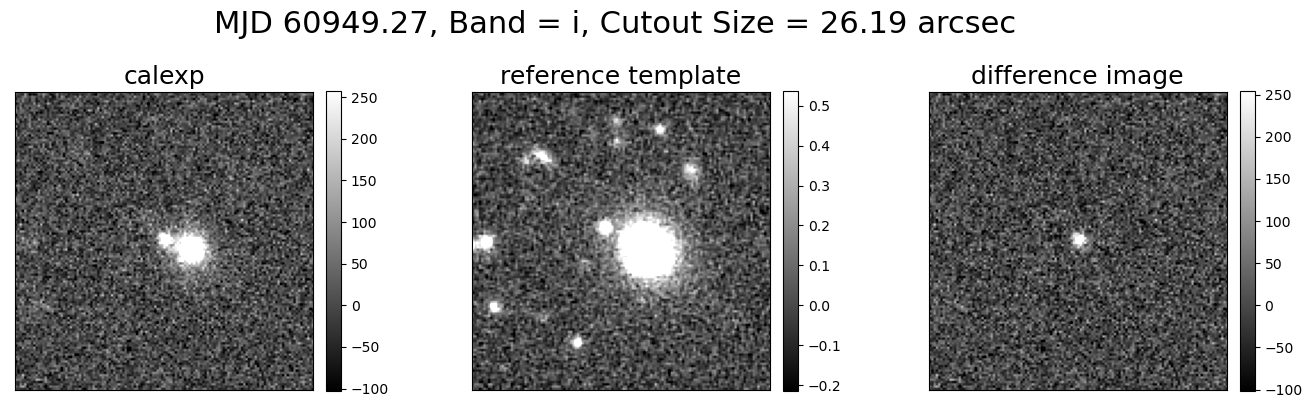

In [41]:
ind = 6 #Defining the index in DiaSource table to display
cutoutsize = 131 #Defining the size of the cutout box in pixels

#-----------
ra = forcedSrc[0]['coord_ra']
dec = forcedSrc[0]['coord_dec']
ccdvisitID = diaSrc[ind]['ccdVisitId']

print('Displaying calexp, difference template, and difference image for diaSource',diaSrc[ind]['diaSourceId'])

visit = str(ccdvisitID)[:-3]
detector = str(ccdvisitID)[-3:]
visit = int(visit)
detector = int(detector)

mjd = diaSrc[ind]['midPointTai']
filt = diaSrc[ind]['filterName']

print('Visit =',visit,', Detector = ', detector)

cutout_diff = cutout_im(butler, ra, dec,diff, visit, detector, cutoutSideLength=cutoutsize)
cutout_ref = cutout_im(butler, ra, dec,difftemp, visit, detector, cutoutSideLength=cutoutsize)
cutout_calexp = cutout_im(butler, ra, dec,calexp, visit, detector, cutoutSideLength=cutoutsize)

# Show subplots | shape: (1,3) 
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
triplet = [cutout_calexp,cutout_ref,cutout_diff]
titles = ['calexp', 'reference template', 'difference image']
for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title('%s' % titles[i],fontsize = 18)
    im_arr = triplet[i].image.array
    _,im_arr_med,im_arr_std = sigma_clipped_stats(im_arr)
    
    minstd = -2
    maxstd = 5
        
    # Create an ImageNormalize object
    norm = ImageNormalize(im_arr-im_arr_med,vmin = minstd * im_arr_std, vmax = maxstd * im_arr_std,
                              stretch=LinearStretch())
    plt.imshow(im_arr, origin='lower', norm=norm, cmap='gray')
    plt.colorbar(fraction=0.046, pad=0.04)


plt.subplots_adjust(wspace=0.4)
plt.suptitle('MJD %.2f, Band = %s, Cutout Size = %.2f arcsec' % (mjd, filt, 0.199918 * cutoutsize),
             y = 0.88, fontsize = 22)
plt.show()

The following cell will output all of the cutout images of a specified filter from the DiaSource table of the supernova into a folder labelled "images."

You can define which type of image cutouts are output (difference image or calexp image) as well as the cutout size. Note that there will be some warnings due to NaNs in the cutouts.

Note also that the cutouts fail for certain images, which is likely due to the coordinates of the supernova falling to close to the edge of a detector.

In [50]:
datasetType = diff #This will output difference image cutouts
#datasetType = calexp #This will output calexp image cutouts
cutoutsize = 131

filt = 'i'
fx = np.where(diaSrc['filterName']==filt)

#--------


#Set first image as reference image
ra = forcedSrc[0]['coord_ra']
dec = forcedSrc[0]['coord_dec']
ccdvisitID = diaSrc[fx][0]['ccdVisitId']

visit = str(ccdvisitID)[:-3]
detector = str(ccdvisitID)[-3:]
visit = int(visit)
detector = int(detector)

im_ref = cutout_im(butler, ra, dec, datasetType, visit, detector, cutoutSideLength=cutoutsize)

#----------

if os.path.exists('images'):
    print('images/ directory already exists')
else:
    os.mkdir('images')
    print('Made an images/ directory')
    
#Clear files out
print('deleting contents of images folder...')
files = glob.glob('images/*')
for f in files:
    os.remove(f)
    
for src in diaSrc[fx]:
    ccdvisitID = src['ccdVisitId']
    visit = str(ccdvisitID)[:-3]
    detector = str(ccdvisitID)[-3:]
    visit = int(visit)
    detector = int(detector)
    try:
        cutout = cutout_im(butler, ra, dec, datasetType, visit, detector, cutoutSideLength=cutoutsize)
        cutout = warp_img(im_ref,cutout, im_ref.getWcs(), cutout.getWcs())
        fig, ax = plt.subplots()

        im_arr = cutout.image.array
        _,im_arr_med,im_arr_std = sigma_clipped_stats(im_arr)
            
        #Set image stretch
        minstd = -2
        maxstd = 3
        
        # Create an ImageNormalize object
        norm = ImageNormalize(im_arr-im_arr_med,vmin = minstd * im_arr_std, vmax = maxstd * im_arr_std,
                              stretch=LinearStretch())

        plt.imshow(im_arr, origin='lower', norm=norm, cmap='gray')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        #plt.title('MJD: '+str(src['midPointTai'])+'; band: '+str(src['filterName']))
        if datasetType==diff:
            plt.title('Difference Image - MJD: %.2f, band: %s' %(src['midPointTai'], src['filterName']))
        elif datasetType==calexp:
            plt.title('Calexp - MJD: %.2f, band: %s' %(src['midPointTai'], src['filterName']))
        else:
            pass
        figname = 'images/cutout_'+str(src['diaSourceId'])+'.png'
        if os.path.isfile(figname):
            os.remove(figname)
        plt.savefig(figname)
        plt.close()
    except:
        print('Image cutout has problems for source '+str(src['diaSourceId']))

images/ directory already exists
deleting contents of images folder...


The following cell will create an animated gif from the contents in the "images" folder and output it as "animation.gif"

In [51]:
make_gif('images')